# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 0.0 Load Data

In [2]:
# load in the data
azdias_chuch = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', chunksize=10000)
customers_chuch = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', chunksize=1000)

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias_raw_data = pd.concat(azdias_chuch)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
customers_raw_data = pd.concat(customers_chuch)

## Part 0.1 Load Support Data

In [5]:
dias_attr_raw = pd.read_excel('./DIAS Attributes - Values 2017.xlsx').drop('Unnamed: 0', axis=1)
dias_information_levels_raw_data = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx').drop('Unnamed: 0', axis=1)


## Part 0.2 Analyse Data

In [6]:
print("azdias : ", azdias_raw_data.shape)
print("customers : ", customers_raw_data.shape)
print("dias_attr_raw : ", dias_attr_raw.shape)
print("dias_information_levels_raw_data : ", dias_information_levels_raw_data.shape)


azdias :  (891221, 366)
customers :  (191652, 369)
dias_attr_raw :  (2258, 4)
dias_information_levels_raw_data :  (313, 4)


In [7]:
azdias_raw_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers_raw_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
dias_attr_raw.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [10]:
dias_information_levels_raw_data.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [11]:
diff_column_information = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']
diff_column_information

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

## Part 0.3 Preprocess dias_attr_raw

In [12]:
dias_attr_raw["Attribute"] = dias_attr_raw["Attribute"].ffill()

dias_attr_raw.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


## Part 0.4 Get & Calculate List Unknown

In [13]:
list_unknown = {}
for index, row in dias_attr_raw.iterrows():
    if(row["Meaning"] == "unknown") :
        # list_unknown[row['Attribute']] = str(row['Value']).split(",");
        list_unknown[row['Attribute']] = [row['Value']];

In [14]:
list_unknown

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': ['-1, 0'],
 'ANREDE_KZ': ['-1, 0'],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': ['-1, 0'],
 'GEOSCORE_KLS7': ['-1, 0'],
 'HAUSHALTSSTRUKTUR': ['-1, 0'],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': ['-1, 0'],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': ['-1, 9'],
 'KBA05_ALTER2': ['-1, 9'],
 'KBA05_ALTER3': ['-1, 9'],
 'KBA05_ALTER4': ['-1, 9'],
 'KBA05_ANHANG': ['-1, 9'],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': ['-1, 9'],
 'KBA05_BAUMAX': ['-1, 0'],
 'KBA05_CCM1': ['-1, 9'],
 'KBA05_CCM2': ['-1, 9'],
 'KBA05_CCM3': ['-1, 9'],
 'KBA05_CCM4': ['-1, 9'],
 'KBA05_DIESEL': ['-

## Part 0.5 Helper Function

In [15]:
def replace_unknown_data_with_nan(val, unkown):
    # print(val, " : ", unkown)
    full_unkown = str(unkown).split(",")
    if str(val) in full_unkown:
        # print("return nan")
        return np.nan
    else:
        return val

In [16]:
def preprocessing_data(target_df, list_unknown):
    for attrib_key,attrib_val in list_unknown.items():        
        if attrib_key in target_df.columns :
            target_df[attrib_key] = target_df[attrib_key].apply(replace_unknown_data_with_nan, args=(attrib_val))

    return target_df

## Part 0.6 Preprocessing Customers & Azdias Data

In [17]:
customers = preprocessing_data(customers_raw_data,list_unknown)

In [18]:
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1.0,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1.0,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2.0,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1.0,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [19]:
azdiaz = preprocessing_data(azdias_raw_data,list_unknown)

In [20]:
azdiaz.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


## Part 0.7 Checkpoint 1 Preprocessing

In [21]:
dias_attr_raw.to_csv('dias_attr_1.csv', index=False)
customers.to_csv('customers_1.csv', index=False)
azdiaz.to_csv('azdias_1.csv', index=False)

## Part 0.8 Clean up Memory usage

In [22]:
del dias_attr_raw
del azdias_raw_data
del customers_raw_data
del azdiaz
del customers

## Part 0.9 Open Checkpoint 1 Preprocessing

In [23]:
dias_attr = pd.read_csv('dias_attr_1.csv')

In [24]:
# load in the data
azdias_batch = pd.read_csv('azdias_1.csv', chunksize=50000)
customers_batch = pd.read_csv('customers_1.csv', chunksize=10000)

In [25]:
customers = pd.concat(customers_batch)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
azdias = pd.concat(azdias_batch)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (891221, 366)
customers :  (191652, 369)
dias_attr :  (2258, 4)


In [28]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [29]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [30]:
dias_attr.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


## Part 0.11 calculate missing column

In [31]:
def get_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
    return missing_value_df

# source : https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset

In [32]:
calculate_missing_customers = get_missing_report(customers)
calculate_missing_azdias = get_missing_report(azdias)

In [33]:
calculate_missing_customers.sort_values('percent_missing', inplace=True, ascending=False)
calculate_missing_azdias.sort_values('percent_missing', inplace=True, ascending=False)

In [34]:
calculate_missing_customers.head(30)

,column_name,percent_missing
7,ALTER_KIND4,99.876860
6,ALTER_KIND3,99.334732
5,ALTER_KIND2,97.338927
4,ALTER_KIND1,93.860748
300,KK_KUNDENTYP,58.406382
1,AGER_TYP,48.059504
100,EXTSEL992,44.498883
149,KBA05_KRSVAN,29.209192
144,KBA05_KRSHERST1,29.209192
136,KBA05_GBZ,29.209192


In [35]:
calculate_missing_azdias.head(20)

,column_name,percent_missing
7,ALTER_KIND4,99.864792
6,ALTER_KIND3,99.307691
5,ALTER_KIND2,96.690047
4,ALTER_KIND1,90.904837
1,AGER_TYP,76.019640
100,EXTSEL992,73.399639
300,KK_KUNDENTYP,65.596749
8,ALTERSKATEGORIE_FEIN,29.504130
61,D19_LETZTER_KAUF_BRANCHE,28.849522
53,D19_GESAMT_ONLINE_QUOTE_12,28.849522


## Part 0.12 Analyse column missing that above threshold 

In [36]:
threshold_missing_rate = 25

In [37]:
def calculate_missing_above_threshold(df) :
    return df[df["percent_missing"] > threshold_missing_rate]

In [38]:
data_missing_customer_above = calculate_missing_above_threshold(calculate_missing_customers)
data_missing_azdias_above = calculate_missing_above_threshold(calculate_missing_azdias)

In [39]:
print("data_missing_customer_above : " , data_missing_customer_above.shape)
data_missing_customer_above.head()

data_missing_customer_above :  (232, 2)


,column_name,percent_missing
7,ALTER_KIND4,99.876860
6,ALTER_KIND3,99.334732
5,ALTER_KIND2,97.338927
4,ALTER_KIND1,93.860748
300,KK_KUNDENTYP,58.406382


In [40]:
print("data_missing_azdias_above : " , data_missing_azdias_above.shape)
data_missing_azdias_above.head()

data_missing_azdias_above :  (17, 2)


,column_name,percent_missing
7,ALTER_KIND4,99.864792
6,ALTER_KIND3,99.307691
5,ALTER_KIND2,96.690047
4,ALTER_KIND1,90.904837
1,AGER_TYP,76.019640


In [41]:
list_data_missing_customers = data_missing_customer_above["column_name"].tolist()
list_data_missing_azdias = data_missing_azdias_above["column_name"].tolist()

In [42]:
print("count list_data_missing_customers : " ,len(list_data_missing_customers) )
print("count list_data_missing_azdias : " ,len(list_data_missing_azdias) )

count list_data_missing_customers :  232
count list_data_missing_azdias :  17


## Part 0.13 Compare both of data missing 

In [43]:
# compare two not match
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

# source : https://stackoverflow.com/questions/35713093/how-can-i-compare-two-lists-in-python-and-return-not-matches

In [44]:
not_match_customers, not_match_asdias = returnNotMatches(list_data_missing_customers,list_data_missing_azdias)

In [45]:
print("count not_match_customers : " ,len(not_match_customers) )
print("count not_match_asdias : " ,len(not_match_asdias) )

count not_match_customers :  224
count not_match_asdias :  9


In [46]:
not_match_asdias

['D19_LETZTER_KAUF_BRANCHE',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_SOZIALES',
 'D19_LOTTO',
 'D19_KONSUMTYP',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_BANKEN_ONLINE_QUOTE_12']

In [47]:
calculate_missing_customers[calculate_missing_customers.column_name.isin(not_match_asdias)]

,column_name,percent_missing
57,D19_KONSUMTYP,24.887296
36,D19_BANKEN_ONLINE_QUOTE_12,24.887296
53,D19_GESAMT_ONLINE_QUOTE_12,24.887296
61,D19_LETZTER_KAUF_BRANCHE,24.887296
62,D19_LOTTO,24.887296
92,D19_VERSI_ONLINE_QUOTE_12,24.887296
69,D19_SOZIALES,24.887296
77,D19_TELKO_ONLINE_QUOTE_12,24.887296
85,D19_VERSAND_ONLINE_QUOTE_12,24.887296


## Part 0.14 Remove Selected missing Column

In [48]:
def get_selected_missing_column() :
    if list_data_missing_customers >= list_data_missing_azdias :
        return list_data_missing_customers
    else :
        return list_data_missing_azdias

In [49]:
selected_missing_column = get_selected_missing_column()
print("selected_missing_column : ", len(selected_missing_column))
for i in selected_missing_column:
    print(i, end=" ")

selected_missing_column :  232
ALTER_KIND4 ALTER_KIND3 ALTER_KIND2 ALTER_KIND1 KK_KUNDENTYP AGER_TYP EXTSEL992 KBA05_KRSVAN KBA05_KRSHERST1 KBA05_GBZ KBA05_HERST1 KBA05_HERST2 KBA05_HERST3 KBA05_HERST4 KBA05_HERST5 KBA05_KRSAQUOT KBA05_KRSOBER KBA05_KRSHERST2 KBA05_KRSHERST3 KBA05_DIESEL KBA05_KRSZUL KBA05_KW1 KBA05_KW2 KBA05_KW3 KBA05_FRAU KBA05_CCM1 KBA05_CCM4 KBA05_ANTG1 MOBI_REGIO KBA05_ALTER1 KBA05_ALTER2 KBA05_ALTER3 KBA05_ALTER4 KBA05_ANHANG KBA05_ANTG2 KBA05_CCM3 KBA05_ANTG3 KBA05_ANTG4 KBA05_AUTOQUOT KBA05_BAUMAX KBA05_MAXBJ KBA05_CCM2 KBA05_MAXAH KBA05_KRSKLEIN KBA05_MAXHERST KBA05_SEG9 KBA05_SEG3 KBA05_SEG4 KBA05_SEG5 KBA05_SEG6 KBA05_SEG7 KBA05_SEG8 KBA05_VORB0 KBA05_SEG10 KBA05_VORB1 KBA05_VORB2 KBA05_ZUL1 KBA05_MAXSEG KBA05_ZUL3 KBA05_ZUL4 KBA05_SEG2 KBA05_ZUL2 KBA05_SEG1 KBA05_MOD4 KBA05_MAXVORB KBA05_MOD1 KBA05_MOD2 KBA05_MOTRAD KBA05_MOD3 KBA05_MOD8 KBA05_MOTOR KKK REGIOTYP VHN W_KEIT_KIND_HH HH_DELTA_FLAG PLZ8_ANTG1 PLZ8_BAUMAX PLZ8_ANTG3 PLZ8_ANTG4 PLZ8_ANTG2 PLZ8_GB

In [50]:
def remove_columns(df):
    """
    Drops given list of columns from df.
    """
    return df.drop(selected_missing_column, axis = 1)

In [51]:
customers = remove_columns(customers)

In [52]:
azdias = remove_columns(azdias)

In [53]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,1.0,...,5.0,3.0,2.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,9.0,11.0,0.0,3.0,0.0,NaN,NaN,NaN,NaN,...,6.0,6.0,3.0,9.0,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,2.0,...,10.0,13.0,11.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,...,6.0,4.0,2.0,9.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,3.0,...,3.0,5.0,4.0,9.0,1,FOOD,MULTI_BUYER,0,1,3


In [54]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,0.0,0.0,2.0,0.0,5.0,1.0,5.0,5.0,...,0.0,1.0,0.0,8.0,11.0,10.0,9.0,5,2,1
2,910225,9.0,17.0,0.0,1.0,0.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,9.0,9.0,6.0,9.0,5,2,3
3,910226,1.0,13.0,0.0,0.0,0.0,2.0,3.0,2.0,2.0,...,0.0,0.0,1.0,7.0,10.0,11.0,9.0,3,2,4
4,910241,1.0,20.0,0.0,4.0,0.0,5.0,3.0,3.0,3.0,...,0.0,0.0,0.0,3.0,5.0,4.0,9.0,4,1,3


## Part 0.15 Checkpoint 2 Cleansing Column

In [55]:
dias_attr.to_csv('dias_attr_2.csv', index=False)
customers.to_csv('customers_2.csv', index=False)
azdias.to_csv('azdias_2.csv', index=False)

In [56]:
del dias_attr
del customers
del azdias

## Part 0.16 Open Checkpoint 2 Cleansing Column

In [57]:
# load in the data
azdias_batch = pd.read_csv('azdias_2.csv', chunksize=50000)
customers_batch = pd.read_csv('customers_2.csv', chunksize=10000)

In [58]:
dias_attr = pd.read_csv('dias_attr_2.csv')
customers = pd.concat(customers_batch)
azdias = pd.concat(azdias_batch)

In [59]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (891221, 134)
customers :  (191652, 137)
dias_attr :  (2258, 4)


## Part 0.17 Analyse Missing Rows

In [60]:
def plot_missing_rowwise_histogram(df1, df2, bins=30, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("No. of Rows vs No. of Missing features")
    ax.set_xlabel("No. of Missing Features")
    ax.set_ylabel("No. of Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

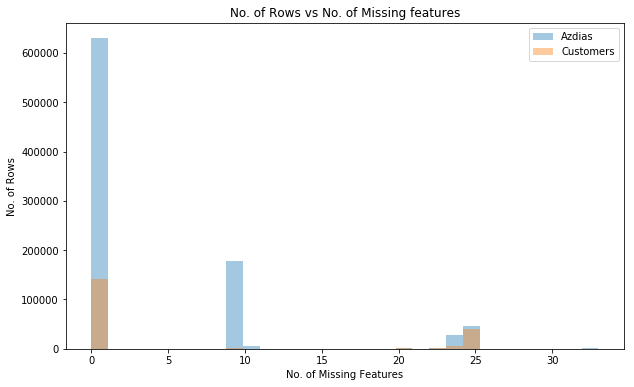

In [61]:
plot_missing_rowwise_histogram(azdias, customers)

## Part 0.18 Remove Missing Rows

In [62]:
threshold_remove_missing_rows = 20

In [63]:
def remove_missing_rows(df):
    total_rows = df.shape[0]
    df = df.dropna(thresh=df.shape[1]-threshold_remove_missing_rows)    
    return df

In [64]:
customers = remove_missing_rows(customers)

In [65]:
azdias = remove_missing_rows(azdias)

In [66]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 134)
customers :  (143724, 137)
dias_attr :  (2258, 4)


In [67]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,1.0,...,5.0,3.0,2.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
2,143872,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,2.0,...,10.0,13.0,11.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,...,6.0,4.0,2.0,9.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,3.0,...,3.0,5.0,4.0,9.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1.0,11.0,0.0,2.0,0.0,4.0,3.0,1.0,1.0,...,1.0,2.0,1.0,9.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3


In [68]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,0.0,0.0,2.0,0.0,5.0,1.0,5.0,5.0,...,0.0,1.0,0.0,8.0,11.0,10.0,9.0,5,2,1
2,910225,9.0,17.0,0.0,1.0,0.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,9.0,9.0,6.0,9.0,5,2,3
3,910226,1.0,13.0,0.0,0.0,0.0,2.0,3.0,2.0,2.0,...,0.0,0.0,1.0,7.0,10.0,11.0,9.0,3,2,4
4,910241,1.0,20.0,0.0,4.0,0.0,5.0,3.0,3.0,3.0,...,0.0,0.0,0.0,3.0,5.0,4.0,9.0,4,1,3
5,910244,1.0,10.0,0.0,1.0,0.0,2.0,5.0,2.0,1.0,...,0.0,0.0,0.0,10.0,7.0,4.0,9.0,4,2,1


In [69]:
diff_column_information = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP']


def adjust_column_customers(df, list_diff_column_information) :
    return df.drop(list_diff_column_information, axis = 1)

In [70]:
customers = adjust_column_customers(customers,diff_column_information)

In [71]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 134)
customers :  (143724, 134)
dias_attr :  (2258, 4)


In [72]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,1.0,...,0.0,0.0,0.0,5.0,3.0,2.0,9.0,3,1,4
2,143872,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,2.0,...,0.0,0.0,0.0,10.0,13.0,11.0,9.0,3,2,4
3,143873,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,...,0.0,0.0,0.0,6.0,4.0,2.0,9.0,1,1,4
4,143874,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,3.0,...,0.0,0.0,0.0,3.0,5.0,4.0,9.0,1,1,3
5,143888,1.0,11.0,0.0,2.0,0.0,4.0,3.0,1.0,1.0,...,0.0,0.0,5.0,1.0,2.0,1.0,9.0,2,1,3


In [73]:
azdias.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,0.0,0.0,2.0,0.0,5.0,1.0,5.0,5.0,...,0.0,1.0,0.0,8.0,11.0,10.0,9.0,5,2,1
2,910225,9.0,17.0,0.0,1.0,0.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,9.0,9.0,6.0,9.0,5,2,3
3,910226,1.0,13.0,0.0,0.0,0.0,2.0,3.0,2.0,2.0,...,0.0,0.0,1.0,7.0,10.0,11.0,9.0,3,2,4
4,910241,1.0,20.0,0.0,4.0,0.0,5.0,3.0,3.0,3.0,...,0.0,0.0,0.0,3.0,5.0,4.0,9.0,4,1,3
5,910244,1.0,10.0,0.0,1.0,0.0,2.0,5.0,2.0,1.0,...,0.0,0.0,0.0,10.0,7.0,4.0,9.0,4,2,1


## Part 0.19 Checkpoint 3 Remove Missing Rows

In [74]:
dias_attr.to_csv('dias_attr_3.csv', index=False)
customers.to_csv('customers_3.csv', index=False)
azdias.to_csv('azdias_3.csv', index=False)

In [75]:
import os

del dias_attr
del customers
del azdias
os.remove("dias_attr_1.csv")
os.remove("customers_1.csv")
os.remove("azdias_1.csv")

## Part 0.20 Open Checkpoint 3 Remove Missing Rows

In [76]:
# load in the data
azdias_batch = pd.read_csv('azdias_3.csv', chunksize=50000)
customers_batch = pd.read_csv('customers_3.csv', chunksize=10000)

In [77]:
dias_attr = pd.read_csv('dias_attr_3.csv')
customers = pd.concat(customers_batch)
azdias = pd.concat(azdias_batch)

In [78]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 134)
customers :  (143724, 134)
dias_attr :  (2258, 4)


## Part 0.21 Check all type data

In [79]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143724 entries, 0 to 143723
Columns: 134 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(44), int64(89), object(1)
memory usage: 146.9+ MB


In [80]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815149 entries, 0 to 815148
Columns: 134 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(44), int64(89), object(1)
memory usage: 833.4+ MB


In [81]:
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]

In [82]:
print("azdias_object_cols : ",azdias_object_cols.values)
print("customer_object_cols : ",customer_object_cols.values)

azdias_object_cols :  ['D19_LETZTER_KAUF_BRANCHE']
customer_object_cols :  ['D19_LETZTER_KAUF_BRANCHE']


In [83]:
dias_information_levels_raw_data = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx').drop('Unnamed: 0', axis=1)


In [84]:
print("dias_information_levels_raw_data : ", dias_information_levels_raw_data.shape)
dias_information_levels_raw_data.head()

dias_information_levels_raw_data :  (313, 4)


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [85]:
dias_information_levels_raw_data[dias_information_levels_raw_data["Attribute"] == "D19_LETZTER_KAUF_BRANCHE"]

,Information level,Attribute,Description,Additional notes


In [86]:
dias_attr[dias_attr["Attribute"] == "D19_LETZTER_KAUF_BRANCHE"]

,Attribute,Description,Value,Meaning


    There is a Attribute that didn't have any information = D19_LETZTER_KAUF_BRANCHE

In [87]:
diff_column_information = ['D19_LETZTER_KAUF_BRANCHE']


def remove_undefined_column(df, list_diff_column_information) :
    return df.drop(list_diff_column_information, axis = 1)

In [88]:
customers = remove_undefined_column(customers,diff_column_information)

In [89]:
azdias = remove_undefined_column(azdias,diff_column_information)

In [90]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 133)
customers :  (143724, 133)
dias_attr :  (2258, 4)


In [91]:
customers.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,1.0,...,0.0,0.0,0.0,5.0,3.0,2.0,9.0,3,1,4
1,143872,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,2.0,...,0.0,0.0,0.0,10.0,13.0,11.0,9.0,3,2,4
2,143873,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,...,0.0,0.0,0.0,6.0,4.0,2.0,9.0,1,1,4
3,143874,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,3.0,...,0.0,0.0,0.0,3.0,5.0,4.0,9.0,1,1,3
4,143888,1.0,11.0,0.0,2.0,0.0,4.0,3.0,1.0,1.0,...,0.0,0.0,5.0,1.0,2.0,1.0,9.0,2,1,3


## Part 0.22 Analyse data in each column

In [92]:
def Get_Percentage_Of_Unique_Value_In_DF(name,df, threshold_unique_percentage) :
    total_data_df = len(df)
    for col in df:
        each_total_unique = len(df[col].unique())
        each_percentage = each_total_unique * 100 /total_data_df
        if each_percentage > 10 :
            print("df : ",name," col ",col, " : ", each_percentage)
        # print(customers[col].unique())
    
### source : https://stackoverflow.com/questions/27241253/print-the-unique-values-in-every-column-in-a-pandas-dataframe

In [93]:
threshold_unique_percentage = 10

percentage_each_column_unique_customers = Get_Percentage_Of_Unique_Value_In_DF("customers",customers, threshold_unique_percentage )
percentage_each_column_unique_azdias = Get_Percentage_Of_Unique_Value_In_DF("azdias",azdias, threshold_unique_percentage )

df :  customers  col  LNR  :  100.0
df :  azdias  col  LNR  :  100.0


In [94]:
customers = remove_undefined_column(customers,["LNR"])
azdias = remove_undefined_column(azdias,["LNR"])

In [95]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 132)
customers :  (143724, 132)
dias_attr :  (2258, 4)


## Part 0.23 Checkpoint 4 Final Clean Data

In [96]:
dias_attr.to_csv('dias_attr_4.csv', index=False)
customers.to_csv('customers_4.csv', index=False)
azdias.to_csv('azdias_4.csv', index=False)

In [97]:
import os

del dias_attr
del customers
del azdias
os.remove("dias_attr_2.csv")
os.remove("customers_2.csv")
os.remove("azdias_2.csv")

In [98]:
# load in the data
azdias_batch = pd.read_csv('azdias_4.csv', chunksize=50000)
customers_batch = pd.read_csv('customers_4.csv', chunksize=10000)

In [99]:
dias_attr = pd.read_csv('dias_attr_4.csv')
customers = pd.concat(customers_batch)
azdias = pd.concat(azdias_batch)

In [100]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 132)
customers :  (143724, 132)
dias_attr :  (2258, 4)


## Part 0.24 Feature Inputter

In [101]:
for key,val in customers.isna().sum().items() :
    if val > 0 :
        print("key : ", key , " total : ", val)

key :  CJT_GESAMTTYP  total :  1881
key :  CJT_KATALOGNUTZER  total :  1881
key :  CJT_TYP_1  total :  1881
key :  CJT_TYP_2  total :  1881
key :  CJT_TYP_3  total :  1881
key :  CJT_TYP_4  total :  1881
key :  CJT_TYP_5  total :  1881
key :  CJT_TYP_6  total :  1881
key :  D19_BANKEN_ONLINE_QUOTE_12  total :  1022
key :  D19_GESAMT_ONLINE_QUOTE_12  total :  1022
key :  D19_KONSUMTYP  total :  1022
key :  D19_LOTTO  total :  1022
key :  D19_SOZIALES  total :  1022
key :  D19_TELKO_ONLINE_QUOTE_12  total :  1022
key :  D19_VERSAND_ONLINE_QUOTE_12  total :  1022
key :  D19_VERSI_ONLINE_QUOTE_12  total :  1022
key :  GFK_URLAUBERTYP  total :  1881
key :  HH_EINKOMMEN_SCORE  total :  2879
key :  KONSUMNAEHE  total :  54
key :  LP_FAMILIE_FEIN  total :  1881
key :  LP_FAMILIE_GROB  total :  1881
key :  LP_LEBENSPHASE_FEIN  total :  1881
key :  LP_LEBENSPHASE_GROB  total :  1881
key :  LP_STATUS_FEIN  total :  1881
key :  LP_STATUS_GROB  total :  1881
key :  ONLINE_AFFINITAET  total :  1881


In [102]:
for key,val in azdias.isna().sum().items() :
    if val > 0 :
        print("key : ", key , " total : ", val)

key :  CJT_GESAMTTYP  total :  2281
key :  CJT_KATALOGNUTZER  total :  2281
key :  CJT_TYP_1  total :  2281
key :  CJT_TYP_2  total :  2281
key :  CJT_TYP_3  total :  2281
key :  CJT_TYP_4  total :  2281
key :  CJT_TYP_5  total :  2281
key :  CJT_TYP_6  total :  2281
key :  D19_BANKEN_ONLINE_QUOTE_12  total :  182845
key :  D19_GESAMT_ONLINE_QUOTE_12  total :  182845
key :  D19_KONSUMTYP  total :  182845
key :  D19_LOTTO  total :  182845
key :  D19_SOZIALES  total :  182845
key :  D19_TELKO_ONLINE_QUOTE_12  total :  182845
key :  D19_VERSAND_ONLINE_QUOTE_12  total :  182845
key :  D19_VERSI_ONLINE_QUOTE_12  total :  182845
key :  GFK_URLAUBERTYP  total :  2281
key :  HH_EINKOMMEN_SCORE  total :  18248
key :  KONSUMNAEHE  total :  468
key :  LP_FAMILIE_FEIN  total :  2281
key :  LP_FAMILIE_GROB  total :  2281
key :  LP_LEBENSPHASE_FEIN  total :  2281
key :  LP_LEBENSPHASE_GROB  total :  2281
key :  LP_STATUS_FEIN  total :  2281
key :  LP_STATUS_GROB  total :  2281
key :  ONLINE_AFFINITA

In [103]:
from sklearn.preprocessing import Imputer

In [104]:
imp = Imputer(missing_values=np.nan, strategy='mean')

In [105]:
imputter_customer = imp.fit_transform(customers)
imputter_azdias = imp.fit_transform(azdias)

In [106]:
def df_add_inputter(target_df,imp) :
    imputter_value = imp.fit_transform(target_df)
    return pd.DataFrame(imputter_value, columns = target_df.columns)

In [107]:
customers = df_add_inputter(customers,imp)
azdias = df_add_inputter(azdias,imp)

In [108]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,1.0,5.0,...,0.0,0.0,0.0,5.0,3.0,2.0,9.0,3.0,1.0,4.0
1,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,2.0,5.0,...,0.0,0.0,0.0,10.0,13.0,11.0,9.0,3.0,2.0,4.0
2,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,1.0,5.0,...,0.0,0.0,0.0,6.0,4.0,2.0,9.0,1.0,1.0,4.0
3,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,3.0,3.0,...,0.0,0.0,0.0,3.0,5.0,4.0,9.0,1.0,1.0,3.0
4,1.0,11.0,0.0,2.0,0.0,4.0,3.0,1.0,1.0,5.0,...,0.0,0.0,5.0,1.0,2.0,1.0,9.0,2.0,1.0,3.0


In [109]:
## validate
for key,val in customers.isna().sum().items() :
    if val > 0 :
        print("key : ", key , " total : ", val)
for key,val in azdias.isna().sum().items() :
    if val > 0 :
        print("key : ", key , " total : ", val)

## Part 0.25 Checkpoint 5 DF Have Inputter

In [110]:
dias_attr.to_csv('dias_attr_5.csv', index=False)
customers.to_csv('customers_5.csv', index=False)
azdias.to_csv('azdias_5.csv', index=False)

In [111]:
import os

del dias_attr
del customers
del azdias

os.remove("dias_attr_3.csv")
os.remove("customers_3.csv")
os.remove("azdias_3.csv")

In [112]:
# load in the data
azdias_batch = pd.read_csv('azdias_5.csv', chunksize=50000)
customers_batch = pd.read_csv('customers_5.csv', chunksize=10000)

In [113]:
dias_attr = pd.read_csv('dias_attr_5.csv')
customers = pd.concat(customers_batch)
azdias = pd.concat(azdias_batch)

In [114]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 132)
customers :  (143724, 132)
dias_attr :  (2258, 4)


## Part 0.27 Feature Scaling

In [115]:
from sklearn.preprocessing import MinMaxScaler


In [116]:
scaler = MinMaxScaler()

In [117]:
scaler.fit(azdias)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [118]:
def MinMaxScalerHelper(df, scaler) :
    return pd.DataFrame(scaler.transform(df), columns = df.columns)

In [119]:
azdias = MinMaxScalerHelper(azdias,scaler)
customers = MinMaxScalerHelper(customers,scaler)


In [120]:
print("azdias : ", azdias.shape)
print("customers : ", customers.shape)
print("dias_attr : ", dias_attr.shape)

azdias :  (815149, 132)
customers :  (143724, 132)
dias_attr :  (2258, 4)


In [121]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,0.476190,0.0,0.044444,0.0,0.8,0.75,0.00,0.00,1.0,...,0.0,0.0,0.0,0.4,0.166667,0.1,1.0,0.4,0.0,0.375
1,0.0,0.285714,0.0,0.022222,0.0,0.2,1.00,0.25,0.25,1.0,...,0.0,0.0,0.0,0.9,1.000000,1.0,1.0,0.4,1.0,0.375
2,0.0,0.380952,0.0,0.000000,0.0,0.2,1.00,0.00,0.00,1.0,...,0.0,0.0,0.0,0.5,0.250000,0.1,1.0,0.0,0.0,0.375
3,0.0,0.952381,0.0,0.088889,0.0,1.0,0.75,0.50,0.50,0.5,...,0.0,0.0,0.0,0.2,0.333333,0.3,1.0,0.0,0.0,0.250
4,0.0,0.523810,0.0,0.044444,0.0,0.6,0.50,0.00,0.00,1.0,...,0.0,0.0,1.0,0.0,0.083333,0.0,1.0,0.2,0.0,0.250


### Part 0.28 Final Data

In [122]:
dias_attr.to_csv('dias_attr_6.csv', index=False)
customers.to_csv('customers_6.csv', index=False)
azdias.to_csv('azdias_6.csv', index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 1.1 Load Data

In [123]:
# load in the data
azdias_batch = pd.read_csv('azdias_6.csv', chunksize=50000)
customers_batch = pd.read_csv('customers_6.csv', chunksize=10000)

In [124]:
dias_attr = pd.read_csv('dias_attr_6.csv')
customers = pd.concat(customers_batch)
azdias = pd.concat(azdias_batch)

In [125]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,0.476190,0.0,0.044444,0.0,0.8,0.75,0.00,0.00,1.0,...,0.0,0.0,0.0,0.4,0.166667,0.1,1.0,0.4,0.0,0.375
1,0.0,0.285714,0.0,0.022222,0.0,0.2,1.00,0.25,0.25,1.0,...,0.0,0.0,0.0,0.9,1.000000,1.0,1.0,0.4,1.0,0.375
2,0.0,0.380952,0.0,0.000000,0.0,0.2,1.00,0.00,0.00,1.0,...,0.0,0.0,0.0,0.5,0.250000,0.1,1.0,0.0,0.0,0.375
3,0.0,0.952381,0.0,0.088889,0.0,1.0,0.75,0.50,0.50,0.5,...,0.0,0.0,0.0,0.2,0.333333,0.3,1.0,0.0,0.0,0.250
4,0.0,0.523810,0.0,0.044444,0.0,0.6,0.50,0.00,0.00,1.0,...,0.0,0.0,1.0,0.0,0.083333,0.0,1.0,0.2,0.0,0.250


## Part 1.2 Analyse PCA

In [126]:
from sklearn.decomposition import PCA

In [127]:
pca_azdias = PCA(n_components=10)

In [128]:
pca_azdias.fit(azdias)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [129]:
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()

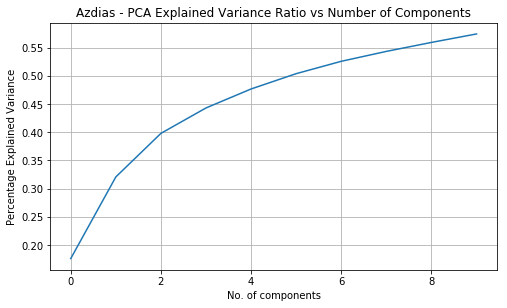

In [130]:
plot_pca_exp_variance(pca_azdias)

In [131]:
pca_8 = PCA(n_components=8)
pca_8.fit(azdias)



PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [132]:
azdias_pca = pca_8.transform(azdias)
customers_pca = pca_8.transform(customers)

In [133]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("Training Cluster Start : ", n)
        
        kmeans = KMeans(n)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        print("Training Cluster Done : ", n, " with scores : ", scores[-1])
        
    return scores, range(K_start, K_end+1, step)

In [134]:
from sklearn.cluster import KMeans

scores, range_ = get_Kmeans_scores(azdias_pca, 1, 15, 1)

Performing K-Means clustering
Given range min:1, max:15, step:1
Training Cluster Start :  1
Training Cluster Done :  1  with scores :  4816934.79203
Training Cluster Start :  2
Training Cluster Done :  2  with scores :  3610318.2603
Training Cluster Start :  3
Training Cluster Done :  3  with scores :  2910250.81196
Training Cluster Start :  4
Training Cluster Done :  4  with scores :  2620671.51632
Training Cluster Start :  5
Training Cluster Done :  5  with scores :  2396546.4586
Training Cluster Start :  6
Training Cluster Done :  6  with scores :  2202653.74581
Training Cluster Start :  7
Training Cluster Done :  7  with scores :  2077336.80577
Training Cluster Start :  8
Training Cluster Done :  8  with scores :  1964039.67146
Training Cluster Start :  9
Training Cluster Done :  9  with scores :  1883948.16699
Training Cluster Start :  10
Training Cluster Done :  10  with scores :  1809691.09987
Training Cluster Start :  11
Training Cluster Done :  11  with scores :  1739966.78332

In [135]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(range_, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

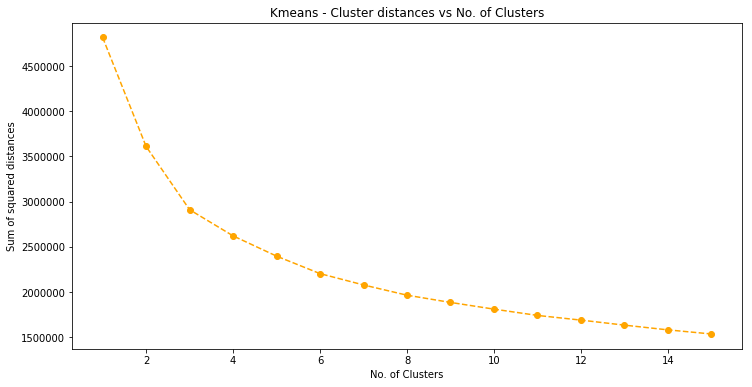

In [136]:
plot_elbow(scores, range_)

### Part 1.3 Customer Report

In [137]:
kmeans = KMeans(6)

kmeans.fit(azdias_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [138]:
azdias_kmeans_result = kmeans.predict(azdias_pca)

azdias_kmeans_result

array([1, 1, 4, ..., 2, 3, 0], dtype=int32)

In [139]:
customers_kmeans_result = kmeans.predict(customers_pca)
customers_kmeans_result

array([0, 4, 0, ..., 0, 5, 5], dtype=int32)

In [140]:
customers_clusters = pd.Series(customers_kmeans_result)
azdias_clusters = pd.Series(azdias_kmeans_result)

In [141]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [142]:
cluster_info

,Cluster,Population,Customers
0,0,158702,36354
1,1,126940,1305
2,2,127131,6531
3,3,107334,1651
4,4,150104,22070
5,5,144938,75813


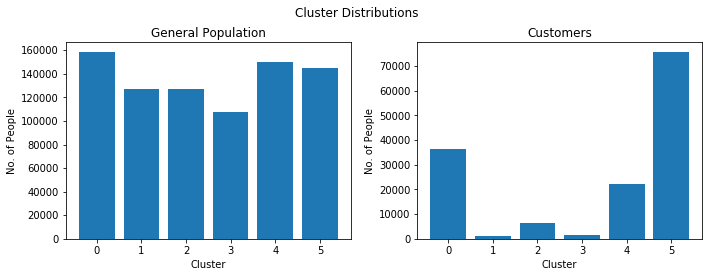

In [143]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [144]:
# load in the data
azdias_batch = pd.read_csv('azdias_6.csv', chunksize=50000)
customers_batch = pd.read_csv('customers_6.csv', chunksize=10000)

In [145]:
dias_attr = pd.read_csv('dias_attr_6.csv')
customers = pd.concat(customers_batch)
azdias = pd.concat(azdias_batch)

In [146]:
mailout_train_raw = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [147]:
print("mailout_train_raw : ", mailout_train_raw.shape)
print("customers : ", customers.shape)
labels = mailout_train_raw["RESPONSE"]

customers.head()

mailout_train_raw :  (42962, 367)
customers :  (143724, 132)


,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,0.476190,0.0,0.044444,0.0,0.8,0.75,0.00,0.00,1.0,...,0.0,0.0,0.0,0.4,0.166667,0.1,1.0,0.4,0.0,0.375
1,0.0,0.285714,0.0,0.022222,0.0,0.2,1.00,0.25,0.25,1.0,...,0.0,0.0,0.0,0.9,1.000000,1.0,1.0,0.4,1.0,0.375
2,0.0,0.380952,0.0,0.000000,0.0,0.2,1.00,0.00,0.00,1.0,...,0.0,0.0,0.0,0.5,0.250000,0.1,1.0,0.0,0.0,0.375
3,0.0,0.952381,0.0,0.088889,0.0,1.0,0.75,0.50,0.50,0.5,...,0.0,0.0,0.0,0.2,0.333333,0.3,1.0,0.0,0.0,0.250
4,0.0,0.523810,0.0,0.044444,0.0,0.6,0.50,0.00,0.00,1.0,...,0.0,0.0,1.0,0.0,0.083333,0.0,1.0,0.2,0.0,0.250


In [148]:
list_unknown = {}
for index, row in dias_attr.iterrows():
    if(row["Meaning"] == "unknown") :
        # list_unknown[row['Attribute']] = str(row['Value']).split(",");
        list_unknown[row['Attribute']] = [row['Value']];

In [149]:
def replace_unknown_data_with_nan(val, unkown):
    # print(val, " : ", unkown)
    full_unkown = str(unkown).split(",")
    if str(val) in full_unkown:
        # print("return nan")
        return np.nan
    else:
        return val


def preprocessing_data(target_df, list_unknown):
    for attrib_key,attrib_val in list_unknown.items():        
        if attrib_key in target_df.columns :
            target_df[attrib_key] = target_df[attrib_key].apply(replace_unknown_data_with_nan, args=(attrib_val))

    return target_df

In [150]:
from sklearn.preprocessing import Imputer

def df_add_inputter(target_df,imp) :
    imputter_value = imp.fit_transform(target_df)
    return pd.DataFrame(imputter_value, columns = target_df.columns)


In [151]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(azdias)



def MinMaxScalerHelper(df, scaler) :
    return pd.DataFrame(scaler.transform(df), columns = df.columns)



In [152]:
def cleansing_transform_data(df,df_target) :
    
    imp = Imputer(missing_values=np.nan, strategy='mean')

    
    df = df[list(df_target)]
    df = preprocessing_data(df,list_unknown)
    df =  df_add_inputter(df,imp)
    return MinMaxScalerHelper(df,scaler)

In [153]:
mailout_train = cleansing_transform_data(mailout_train_raw,customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [154]:
print("mailout_train : ", mailout_train.shape)

mailout_train.head()

mailout_train :  (42962, 132)


,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,8.0,0.0,1.0,0.0,2.0,5.0,2.0,2.0,5.0,...,0.0,0.0,1.0,5.0,2.0,1.0,9.0,3.0,2.0,4.0
1,4.0,13.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,4.0,...,0.0,0.0,1.0,1.0,2.0,1.0,9.0,1.0,2.0,3.0
2,1.0,9.0,0.0,0.0,0.0,4.0,5.0,1.0,1.0,5.0,...,0.0,0.0,4.0,6.0,4.0,2.0,9.0,3.0,1.0,4.0
3,1.0,6.0,0.0,2.0,0.0,2.0,5.0,2.0,2.0,5.0,...,0.0,0.0,1.0,8.0,11.0,11.0,9.0,3.0,2.0,4.0
4,1.0,9.0,0.0,1.0,0.0,6.0,5.0,1.0,2.0,5.0,...,0.0,0.0,0.0,2.0,2.0,1.0,9.0,3.0,1.0,3.0


## Part 2.2  Model Selection

In [155]:
from sklearn.model_selection import train_test_split, cross_val_score


In [156]:
X_train_red, X_val_red, y_train_red, y_val_red = train_test_split(mailout_train, labels,stratify=labels, test_size=0.2)

In [157]:
X_train_red.head()

,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,TITEL_KZ,UNGLEICHENN_FLAG,VHA,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
36696,1.000000,18.000000,0.00000,2.000000,0.000000,6.0,2.0,4.0,2.0,4.0,...,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,9.000000,4.0,2.0,3.0
25391,1.000000,10.000000,0.00000,3.000000,0.000000,1.0,5.0,2.0,2.0,5.0,...,0.000000,1.000000,0.000000,6.000000,3.000000,2.000000,9.000000,3.0,2.0,4.0
16089,1.525241,10.285556,0.08899,2.017087,0.009585,2.0,4.0,2.0,1.0,5.0,...,0.007918,0.071264,1.137443,4.318644,4.505953,3.116963,8.729947,3.0,2.0,1.0
7149,1.000000,21.000000,1.00000,3.000000,0.000000,1.0,1.0,2.0,3.0,3.0,...,0.000000,0.000000,0.000000,3.000000,6.000000,5.000000,6.000000,4.0,1.0,3.0
33427,1.000000,21.000000,0.00000,6.000000,0.000000,3.0,4.0,3.0,1.0,4.0,...,0.000000,0.000000,5.000000,2.000000,3.000000,3.000000,9.000000,1.0,1.0,4.0


In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import time
from sklearn.model_selection import GridSearchCV

SEED = 2

In [159]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed  

In [160]:
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED))]

results_reduced = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train_red, y_train_red, X_val_red, y_val_red)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    results_reduced["Time_in_sec"].append(time_)
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.677756,4.32021
1,DecisionTreeClassifier,0.523673,1.20045
2,RandomForestClassifier,0.583718,0.797185
3,GradientBoostingClassifier,0.744328,17.9662
4,AdaBoostClassifier,0.727555,6.07132


## Part 2.3 Train Model

In [161]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=SEED), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [162]:
adaboost_grid.fit(X_train_red, y_train_red)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   4.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   4.6s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   4.6s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   4.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=   4.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=   9.3s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=   9.3s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=100 .........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=100, total=   9.7s
[CV] algorithm=SAMME.R, learning_rate=0

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.5min finished


Best Score:  0.770352053847
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}


In [163]:
preds_adaboost = best_adaboost.predict_proba(X_val_red)[:,1]

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val_red, preds_adaboost)))

ROC score on validation data: 0.7322


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [164]:
mailout_test_raw = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [165]:
mailout_test_LNR = mailout_test_raw["LNR"]

mailout_test = cleansing_transform_data(mailout_test_raw,customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [166]:
preds_test_adaboost = best_adaboost.predict_proba(mailout_test)[:,1]

In [167]:
kaggle_adaboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)

In [168]:
kaggle_adaboost.head()

,RESPONSE
LNR,
1754,0.332197
1770,0.332197
1465,0.248535
1470,0.247213
1478,0.240376


In [169]:
kaggle_adaboost.to_csv("kaggle_thomas_udacity.csv")